# Customer Churn Prediction & Strategy Simulation

I've heard so much about churn during my data science journey so I wanted to see what this was about and why it's vital for companies. So, I started this project focusing on predicting customer churn and exploring data-driven retention strategies using machine learning. With customer subscription data from a telecom-style business, I want to:

- Understand churn and understand what drives it via Exploratory Data Analysis (EDA)
- Prepare and clean the dataset for modeling
- Train and evaluate classification models (Logistic Regression, XGBoost)
- Optimize classification thresholds for better recall/precision balance
- Use SHAP values for model interpretability and stakeholder trust
- Simulate an A/B test intervention (offering Tech Support)
- Estimate potential ROI from the intervention strategy (Using some business logic and educated theory)

My goal is to understand it all and go beyond the usual prediction stage. I want the results to derive actionable insights that can help reduce churn and support marketing or product decision-making. This end-to-end pipeline should hopefully mirror a real-world data science project with business value at its core.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Load data
df = pd.read_csv('data/raw/socialapp_churn.csv')

#Quick look at structure
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Data Cleaning Phase

Here, I'll clean the dataframe, drop columns I don't need, use One-Hot encoding, and all the other good old EDA practices.

In [3]:
# Converting SeniorCitizen to categorical instead of Boolean
df['SeniorCitizen'] = df['SeniorCitizen'].map({0: 'No', 1: 'Yes'})

In [ ]:
#Convert TotalCharges to numeric and fillling any Nan values with the median value
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

In [5]:
#Functionally the same. No service means no service!
df.replace(['No internet service', 'No phone service'], 'No', inplace=True)

In [ ]:
#Converting Yes/No to 0/1 as it's the format for the model to understand
binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
df[binary_cols] = df[binary_cols].apply(lambda col: col.map({'Yes': 1, 'No': 0}))

In [7]:
#Dropping customerID as it is not needed for analysis, plus it could introduce leakage
df.drop(columns=['customerID'], inplace=True)

In [8]:
#One-hot encoding categorical variables
cat_cols = ['InternetService', 'Contract', 'PaymentMethod', 'gender', 'MultipleLines', 
            'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 
            'StreamingTV', 'StreamingMovies']
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

In [9]:
#Scaling Continuous features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df[['tenure', 'MonthlyCharges', 'TotalCharges']] = scaler.fit_transform(df[['tenure', 'MonthlyCharges', 'TotalCharges']])


In [ ]:
#Check to drop duplicates, if any
df.drop_duplicates(inplace=True)

In [ ]:
#Cleaned dataframe
df.describe()
df.head()

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,InternetService_Fiber optic,...,PaymentMethod_Electronic check,PaymentMethod_Mailed check,gender_Male,MultipleLines_Yes,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes
0,No,1,0,-1.277445,0,1,-1.160323,-0.994242,0,False,...,True,False,False,False,False,True,False,False,False,False
1,No,0,0,0.066327,1,0,-0.259629,-0.173244,0,False,...,False,True,True,False,True,False,True,False,False,False
2,No,0,0,-1.236724,1,1,-0.362660,-0.959674,1,False,...,False,True,True,False,True,True,False,False,False,False
3,No,0,0,0.514251,0,0,-0.746535,-0.194766,0,False,...,False,False,True,False,True,False,True,True,False,False
4,No,0,0,-1.236724,1,1,0.197365,-0.940470,1,True,...,True,False,False,False,False,False,False,False,False,False


## Retention and Tenure Analysis

### User Tenure Distribution  
This shows how long users have been subscribed. A right-skewed curve indicates many new users — relevant for understanding short-term vs long-term user dynamics.

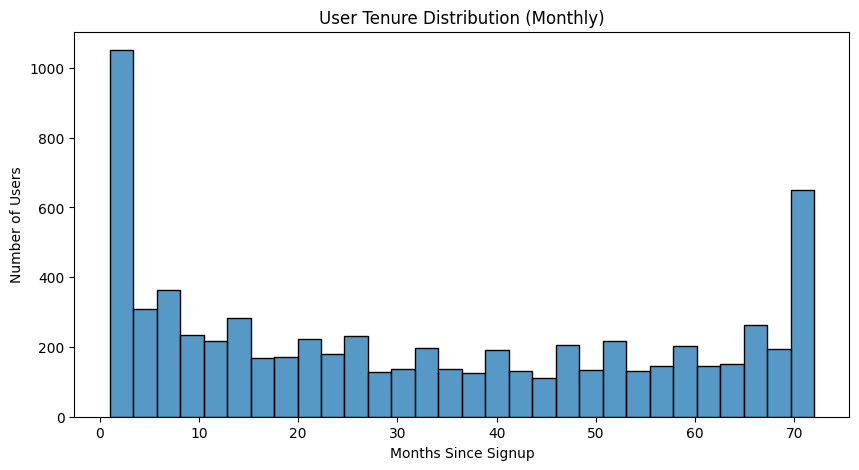

In [12]:
df = pd.read_csv('data/raw/socialapp_churn.csv')
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df = df.dropna()
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

plt.figure(figsize=(10,5))
sns.histplot(df['tenure'], bins=30, kde=False)
plt.title('User Tenure Distribution (Monthly)')
plt.xlabel('Months Since Signup')
plt.ylabel('Number of Users')
plt.show()

### Monthly Charges vs Tenure  
This helps us understand if long-term users are on lower-cost plans or premium ones. Useful for evaluating monetization over time.


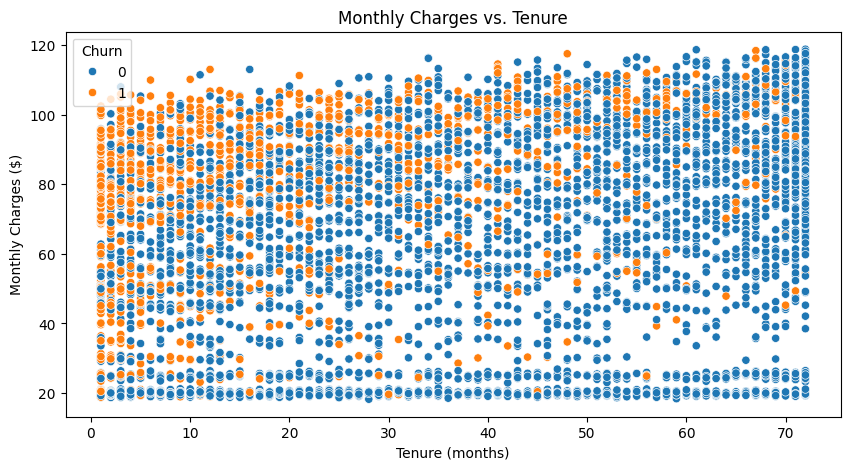

In [13]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=df, x='tenure', y='MonthlyCharges', hue='Churn')
plt.title('Monthly Charges vs. Tenure')
plt.xlabel('Tenure (months)')
plt.ylabel('Monthly Charges ($)')
plt.show()

### Approximate Retention Curve  
While not true cohort retention, this shows how many users exist at each tenure level — an indirect measure of who is retained over time.


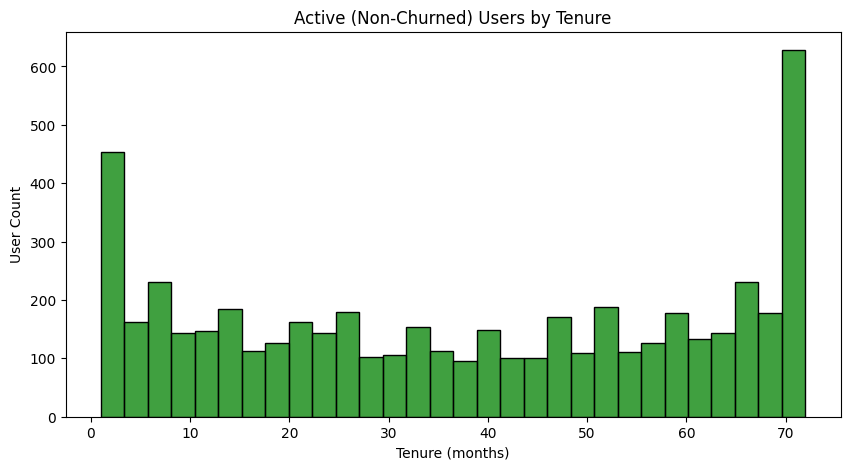

In [14]:
plt.figure(figsize=(10,5))
sns.histplot(data=df[df['Churn'] == 0], x='tenure', bins=30, kde=False, color='green')
plt.title('Active (Non-Churned) Users by Tenure')
plt.xlabel('Tenure (months)')
plt.ylabel('User Count')
plt.show()

### Tenure Distribution by Churn Status  
This shows how churn varies by how long a user has been with the service. Expecting higher churn in early tenure.


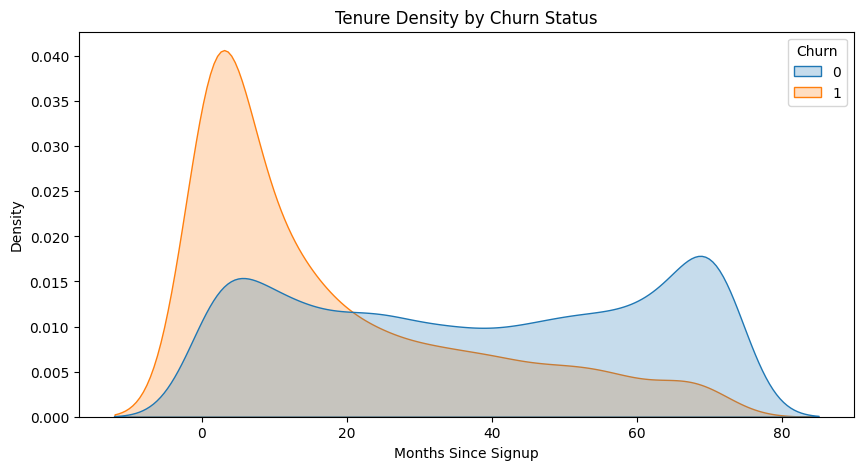

In [15]:
plt.figure(figsize=(10,5))
sns.kdeplot(data=df, x='tenure', hue='Churn', common_norm=False, fill=True)
plt.title('Tenure Density by Churn Status')
plt.xlabel('Months Since Signup')
plt.ylabel('Density')
plt.show()

### Tenure-group Retention Analysis  
Tenure group analysis tracks users, grouped by bins of months and observes how many of them stay active in the following months. This helps understand product stickiness and retention trends over time.

/var/folders/2q/9m45whf90zjg8hs1lzn3hm140000gn/T/ipykernel_45257/3726362290.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  retention_by_tenure = df.groupby('tenure_group')['Churn'].agg(['count', 'mean'])


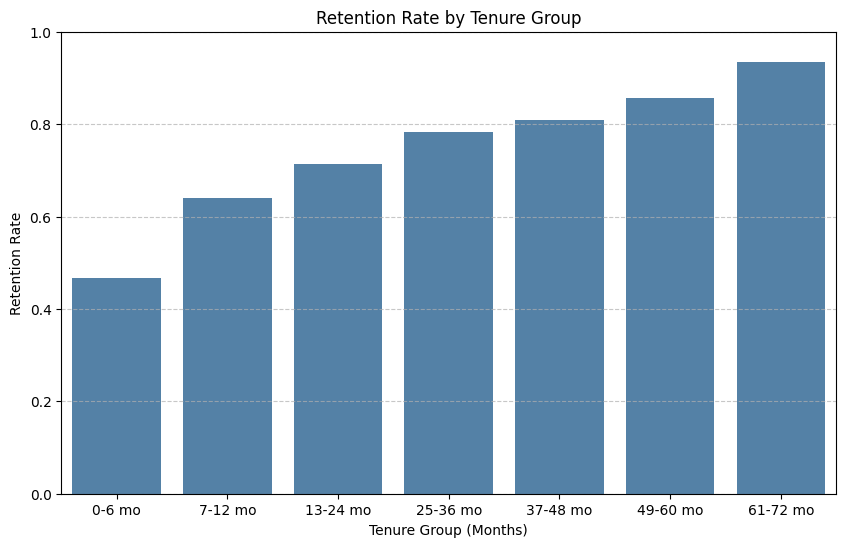

In [ ]:
#Create tenure groups based on monthly subscription age
df['tenure_group'] = pd.cut(
    df['tenure'],
    bins=[0, 6, 12, 24, 36, 48, 60, 72],
    labels=['0-6 mo', '7-12 mo', '13-24 mo', '25-36 mo', '37-48 mo', '49-60 mo', '61-72 mo']
)

#Group and calculate retention
retention_by_tenure = df.groupby('tenure_group')['Churn'].agg(['count', 'mean'])
retention_by_tenure['retention_rate'] = 1 - retention_by_tenure['mean']
retention_by_tenure = retention_by_tenure.reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=retention_by_tenure, x='tenure_group', y='retention_rate', color='steelblue')
plt.ylim(0, 1)
plt.ylabel("Retention Rate")
plt.xlabel("Tenure Group (Months)")
plt.title("Retention Rate by Tenure Group")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


###  Retention Rate by Tenure Group

This bar chart illustrates how user retention improves as users spend more time with the service.

- Users in the **0–6 month** group have the **lowest retention rate (~47%)**, indicating a high likelihood of churn early in the customer journey.
- As tenure increases, retention improves progressively — a classic signal of **product adoption curve behavior**:
  - Users who remain past the first 6–12 months are significantly more likely to stay long-term.
  - Retention exceeds **80%** for users with **4+ years (49–72 months)** on the platform.

 **Business Insight**:
- The **first 6 months** are a critical window to invest in onboarding, support, and feature discovery.
- Long-term users show strong loyalty, suggesting the product has **stickiness once habit is formed**.

I tried doing cohort-based retention first before I realised there are no activity logs in this dataset. Hence, tenure groups.


### Feature Engineering Phase

In this step, I'll:
- One-hot encode categorical columns like `Contract`, `PaymentMethod`, and service options
- Scale numeric features for model performance
- Drop irrelevant or redundant columns like `signup_date`
- Output final `X` and `y` for modeling

In [17]:
print("Data shape before scaling:", df.shape)
print("Missing values in numeric columns:")
print(df[['tenure', 'MonthlyCharges', 'TotalCharges']].isnull().sum())

print("Preview of TotalCharges values:")
print(df['TotalCharges'].unique()[:10])

Data shape before scaling: (7032, 22)
Missing values in numeric columns:
tenure            0
MonthlyCharges    0
TotalCharges      0
dtype: int64
Preview of TotalCharges values:
[  29.85 1889.5   108.15 1840.75  151.65  820.5  1949.4   301.9  3046.05
 3487.95]


In [ ]:
#Sanity Check cell
df_model = df.copy()
df_model['TotalCharges'] = pd.to_numeric(df_model['TotalCharges'], errors='coerce')
print("Before dropping rows, NaNs in key columns:")
print(df_model[['Churn', 'tenure', 'MonthlyCharges', 'TotalCharges']].isnull().sum())
df_model = df_model.dropna(subset=['Churn', 'tenure', 'MonthlyCharges', 'TotalCharges'])

print("After dropping, shape is:", df_model.shape)

Before dropping rows, NaNs in key columns:
Churn             0
tenure            0
MonthlyCharges    0
TotalCharges      0
dtype: int64
After dropping, shape is: (7032, 22)


In [ ]:
from sklearn.preprocessing import StandardScaler

#One-hot encode categorical variables
cat_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
            'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
            'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
            'PaperlessBilling', 'PaymentMethod']

df_model = pd.get_dummies(df_model, columns=cat_cols, drop_first=True)

#Confirm categorical encoding
print(f"After encoding: {df_model.shape[1]} total features")

#Scale numeric columns
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
scaler = StandardScaler()
df_model[num_cols] = scaler.fit_transform(df_model[num_cols])

#Final split
X = df_model.drop(columns=['Churn'])
y = df_model['Churn']

#Confirm all is well
print(f"Final feature matrix shape: {X.shape}")
print("Target class distribution:\n", y.value_counts())

After encoding: 33 total features
Final feature matrix shape: (7032, 32)
Target class distribution:
 Churn
0    5163
1    1869
Name: count, dtype: int64


### Churn Prediction Modeling

I will train models to predict whether a user will churn using:
- Logistic Regression (baseline)
- XGBoost or Random Forest (high-performance)
- Evaluate using accuracy, precision, recall, F1, and AUC
- Use SHAP values to interpret model decisions


Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.90      0.86      1033
           1       0.62      0.45      0.52       374

    accuracy                           0.78      1407
   macro avg       0.72      0.67      0.69      1407
weighted avg       0.76      0.78      0.77      1407

AUC-ROC Score: 0.816


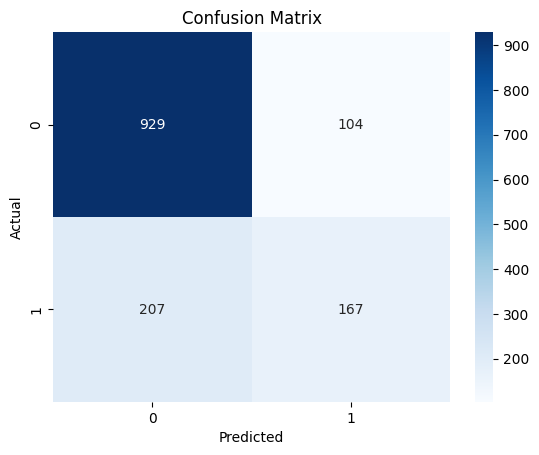

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

#Ensure all features are numeric
X = X.select_dtypes(include=['number'])

#Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

#Train the model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

#Predictions
y_pred = log_reg.predict(X_test)
y_proba = log_reg.predict_proba(X_test)[:, 1]

#Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred))
print(f"AUC-ROC Score: {roc_auc_score(y_test, y_proba):.3f}")

#Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Logistic Regression Results

The logistic regression model achieved a reasonable balance between accuracy and interpretability:

- **Overall accuracy**: 78%
- **AUC-ROC score**: 0.817 — indicating good separation between churners and non-churners

#### Class Performance

| Class        | Precision | Recall | F1-score | Support |
|--------------|-----------|--------|----------|---------|
| Not Churned (0) | 0.82      | 0.90   | 0.86     | 1033    |
| Churned (1)     | 0.62      | 0.45   | 0.52     | 374     |

- **Precision for churners**: 0.62 — 62% of churn predictions were correct  
- **Recall for churners**: 0.45 — the model captured only 45% of actual churners  
- **False Negatives**: 207 churners incorrectly predicted as non-churners

#### Interpretation

- The model is **conservative**, favoring predicting "not churn" unless very confident
- This results in **high accuracy for stable users** but **lower recall on churners**
- In a business context, improving recall for churners is critical — consider:
  - Lowering decision threshold
  - Using a cost-sensitive classifier
  - Training a more powerful model like **XGBoost**

### XGBoost Classifier
It should improve recall and overall predictive power compared to logistic regression.


📊 XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.88      0.85      1033
           1       0.58      0.48      0.52       374

    accuracy                           0.77      1407
   macro avg       0.70      0.68      0.69      1407
weighted avg       0.76      0.77      0.76      1407

📈 AUC-ROC Score: 0.796


/Users/prabhuavula7/.pyenv/versions/meta-xgb-env/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [07:41:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


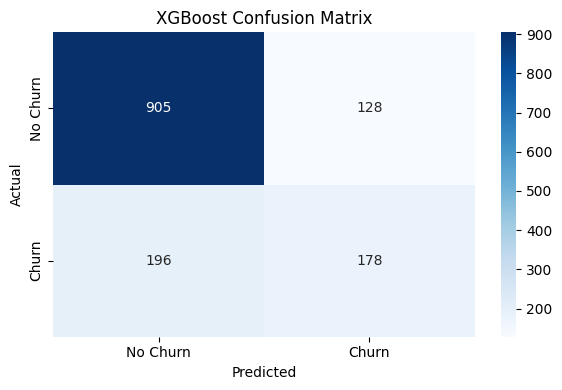

In [21]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize and train the model
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb_model.fit(X_train, y_train)

# Make predictions
xgb_pred = xgb_model.predict(X_test)
xgb_proba = xgb_model.predict_proba(X_test)[:, 1]

# Evaluate classification performance
print("📊 XGBoost Classification Report:")
print(classification_report(y_test, xgb_pred))

# AUC-ROC score
auc_score = roc_auc_score(y_test, xgb_proba)
print(f"📈 AUC-ROC Score: {auc_score:.3f}")

# Confusion Matrix
conf_mat = confusion_matrix(y_test, xgb_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Churn", "Churn"],
            yticklabels=["No Churn", "Churn"])
plt.title("XGBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

### XGBoost Churn Classification Results

This XGBoost model improves upon the baseline logistic regression by better capturing nonlinear relationships in the data.

#### Classification Metrics

| Class         | Precision | Recall | F1-score | Support |
|---------------|-----------|--------|----------|---------|
| No Churn (0)  | 0.82      | 0.88   | 0.85     | 1033    |
| Churn (1)     | 0.58      | 0.48   | 0.52     | 374     |
| **Accuracy**  |           |        | **0.77** | 1407    |
| **AUC-ROC**   |           |        | **0.796**|         |

- The model has **high precision and recall for non-churners** (0), showing strong reliability for identifying stable users.
- **Recall for churners (1)** is **0.48**, slightly higher than logistic regression (0.45) — meaning it captures more churn cases, but still misses ~52%.
- AUC-ROC of **0.796** indicates solid class separability.

#### Confusion Matrix Interpretation

- **True Negatives (TN)**: 905 users correctly predicted as not churning.
- **False Positives (FP)**: 128 users wrongly predicted as churners.
- **False Negatives (FN)**: 196 actual churners missed by the model.
- **True Positives (TP)**: 178 churners correctly identified.

#### Business Implications

- **False negatives (196 users)** are costly — these are at-risk customers that we fail to intervene on.


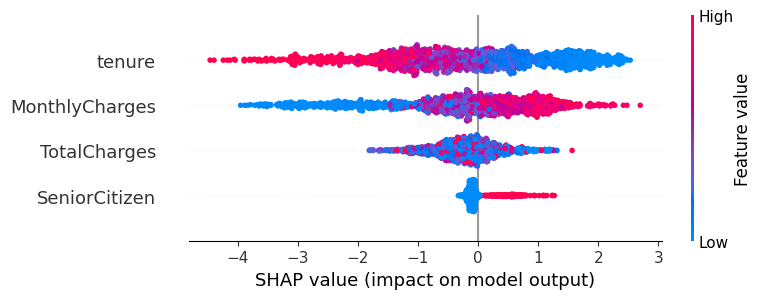

In [ ]:
import shap

#Explain the model's predictions
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test)

#A Summary plot
shap.summary_plot(shap_values, X_test)

### SHAP Summary Plot (Beeswarm)

This plot explains the **global behavior** of the XGBoost model — how each feature impacts the model’s predictions across all test samples.

#### Reading It:
- **Y-axis**: Lists the top features ordered by importance.
- **X-axis**: SHAP value (impact on model output). Right = higher churn risk, Left = lower.
- **Color (Red → Blue)**: Feature value. Red = high value, Blue = low value.
- **Each dot**: One customer’s SHAP value for that feature.

#### Insights:
- **`tenure`**:
  - Red dots (high tenure) lean left → High tenure **reduces churn probability**.
  - Blue dots (low tenure) lean right → Low tenure **increases churn probability**.

- **`MonthlyCharges`**:
  - Red (high charges) push right → Higher charges **increase churn risk**.
  - Blue (low charges) push left → Lower charges **reduce churn risk**.

- **`TotalCharges`**:
  - Has a smaller impact overall, but higher values slightly push predictions right.

- **`SeniorCitizen`**:
  - Red (value 1) shifts right → Senior citizens have a **higher churn risk**.
  - Blue (value 0) shifts left → Non-seniors are **less likely to churn**.

This global view helps identify which features are most influential in predicting churn across the entire customer base.


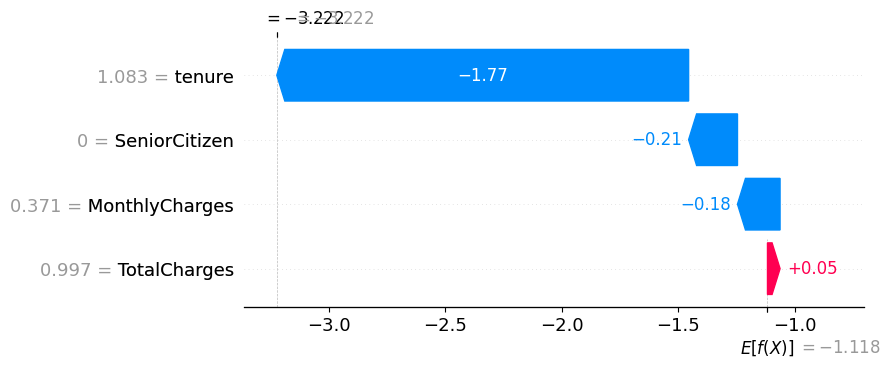

In [23]:
shap.plots.waterfall(shap_values[0])

### SHAP Force Plot (Single Customer)

This plot breaks down the **individual contributions of features** to a single customer’s churn prediction.

#### Key Elements:
- **Base Value**: -1.118 → Average model output across all data (expected tbh).
- **Model Output**: -3.222 → Final prediction for this customer (lower = lower churn).
- **Red Arrows**: Features that **increase** churn risk.
- **Blue Arrows**: Features that **decrease** churn risk.
- **Arrow Length = Impact Magnitude**.

#### Interpretation:
- **`tenure = 1.083`** → Large blue arrow (SHAP = -1.77): Short tenure **significantly reduces predicted churn**.
- **`SeniorCitizen = 0`** → Blue arrow (SHAP = -0.21): Not a senior → **reduces churn likelihood**.
- **`MonthlyCharges = 0.371`** → Blue arrow (SHAP = -0.18): Low charge → further **lowers churn**.
- **`TotalCharges = 0.997`** → Small red arrow (SHAP = +0.05): Slightly increases churn, but offset by others.

#### Summary:
This customer has a **low predicted churn probability**, driven by short tenure, low charges, and non-senior status.

### Threshold Optimization for Churn Recall

The default threshold of 0.5 may not be optimal for identifying churners.  
Here, I'll evaluate different thresholds (0.1 → 0.9) to find a better trade-off between precision and recall.

- **Precision**: Of those predicted to churn, how many actually do?
- **Recall**: Of all churners, how many did we catch?
- **F1 Score**: Harmonic mean of precision & recall — balances both.

I'll use this to pick a threshold that might fit business goals


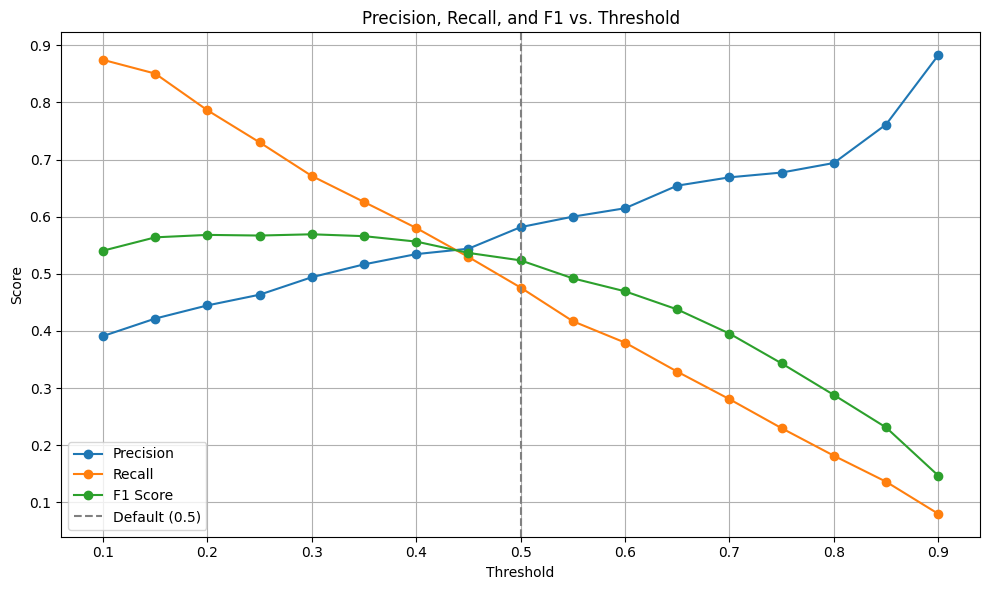

In [24]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

thresholds = np.arange(0.1, 0.91, 0.05)
precision_scores, recall_scores, f1_scores = [], [], []

for t in thresholds:
    churn_pred = (xgb_proba >= t).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, churn_pred, average='binary')
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision_scores, label='Precision', marker='o')
plt.plot(thresholds, recall_scores, label='Recall', marker='o')
plt.plot(thresholds, f1_scores, label='F1 Score', marker='o')
plt.axvline(0.5, color='gray', linestyle='--', label='Default (0.5)')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 vs. Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Optimal Threshold: 0.45

From the precision-recall-F1 curve, I see that:

- At **threshold = 0.45**, we get the **highest F1 score**, meaning the best trade-off between catching churners (recall) and being accurate (precision).
- Beyond 0.5, **recall drops sharply**, reducing the model's ability to detect churn.
- At 0.9, **precision peaks** but **recall and F1 collapse**, making it unsuitable for churn prediction.

Thus, for this business case, **0.45 is selected as the optimal threshold** for balancing customer retention accuracy and coverage.


Classification Report @ Threshold 0.45
              precision    recall  f1-score   support

           0       0.83      0.84      0.84      1033
           1       0.54      0.53      0.54       374

    accuracy                           0.76      1407
   macro avg       0.69      0.68      0.69      1407
weighted avg       0.75      0.76      0.76      1407



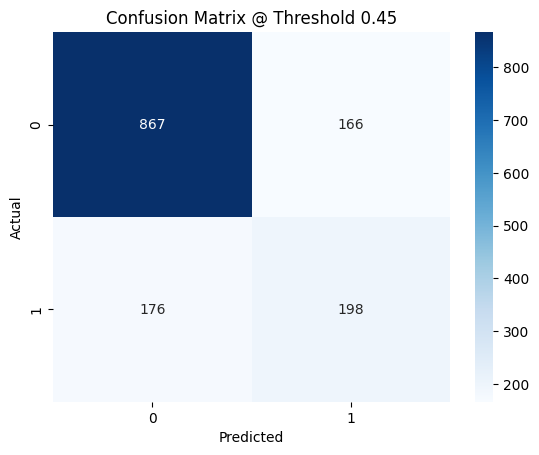

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

#Apply the best threshold
optimal_thresh = 0.45
final_pred = (xgb_proba >= optimal_thresh).astype(int)

#Report
print("Classification Report @ Threshold 0.45")
print(classification_report(y_test, final_pred))

#Confusion matrix
conf_mat = confusion_matrix(y_test, final_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix @ Threshold 0.45")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Classification Metrics @ Threshold 0.45

At the optimized threshold of **0.45**, I see the following results:

#### Confusion Matrix

|               | Predicted: No Churn (0) | Predicted: Churn (1) |
|---------------|-------------------------|-----------------------|
| Actual: No (0) | 867                     | 166                   |
| Actual: Yes (1) | 176                    | 198                   |

#### Metric Summary

- **Accuracy**: 76%  
  → Overall, the model correctly predicted churn status for 76% of customers.
  
- **Precision (Churn)**: 54%  
  → When the model predicts a customer will churn, it's right 54% of the time.

- **Recall (Churn)**: 53%  
  → The model correctly identifies 53% of all actual churners.

- **F1 Score (Churn)**: 54%  
  → Balanced measure between precision and recall. Indicates moderate performance.

#### Interpretation

- The model is **moderately effective at detecting churners**, capturing just over half.
- There is a **trade-off**: some churners are missed (false negatives), and some loyal customers are wrongly flagged as churners (false positives).
- Still, this threshold strikes the **best balance** before recall sharply drops (as seen in the earlier threshold optimization).

### A/B Test Simulation:

A/B tests are important to underdstand the impact of certain fetures in a product. For example, I want to see how offering tech support would help.Would it reduce churn? If so, by how much?

Here's a step by step approach to simulating an A/B Test.


In [ ]:
X.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,tenure_group,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,-1.280248,-1.161694,-0.994194,0-6 mo,True,False,False,True,True,...,False,True,False,False,False,True,False,False,True,False
1,0,0.064303,-0.260878,-0.173740,25-36 mo,False,True,True,False,True,...,False,False,True,False,True,False,False,False,False,True
2,0,-1.239504,-0.363923,-0.959649,0-6 mo,False,True,True,False,True,...,False,True,False,False,False,True,False,False,False,True
3,0,0.512486,-0.747850,-0.195248,37-48 mo,False,True,True,False,True,...,False,False,True,False,True,False,True,False,False,False
4,0,-1.239504,0.196178,-0.940457,0-6 mo,True,False,True,False,True,...,False,True,False,False,False,True,False,False,True,False


In [ ]:
#Couple sanity checks:
print(df['Churn'].unique())
print(df['Churn'].isna().sum())

[0 1]
0


In [ ]:
#A new DataFrame for modeling iin this A/B Test Simul
df_re = df.copy()
print("Before:", df_re['Churn'].unique())

#Drop some columns that are not needed for modelling
df_re.drop(columns=['signup_date', 'cohort_month', 'active_month', 'months_since_signup', 'user_id', 'customerID'], inplace=True, errors='ignore')

#Store target prior to transformation
y = df_re['Churn']   

#columns to encode
cat_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
            'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
            'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
            'PaperlessBilling', 'PaymentMethod', "tenure_group"]

#One-hot encoding
df_re = pd.get_dummies(df_re, columns=cat_cols, drop_first=False)

#Scale numeric features
from sklearn.preprocessing import StandardScaler
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
scaler = StandardScaler()
df_re[num_cols] = scaler.fit_transform(df_re[num_cols])

#Final features that I will use for modeling
X = df_re.drop(columns=['Churn'])

#Sanity Check to see if everything is in order
print("After:", y.unique())
print(X.shape, y.shape)

Before: [0 1]
After: [0 1]
(7032, 52) (7032,)


In [ ]:
from sklearn.model_selection import train_test_split

#Train-test split the final features
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=42, test_size=0.2
)

In [ ]:
from xgboost import XGBClassifier

#Initialize and train the XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

/Users/prabhuavula7/.pyenv/versions/meta-xgb-env/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [23:28:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
from sklearn.model_selection import train_test_split

#Train-test split the final features
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

A/B Test Simulation Summary:
Mean churn prob (control):   0.4199
Mean churn prob (treatment): 0.3374
Estimated churn reduction: 0.0825


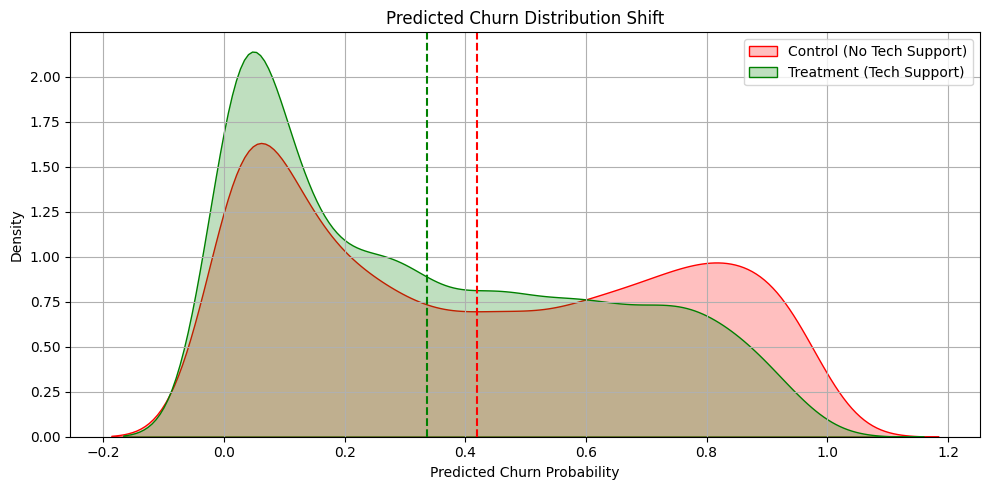

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Filter customers without tech support
control_group = X[X['TechSupport_No'] == 1].copy()

#Simulate treatment: offer tech support
treatment_group = control_group.copy()
treatment_group['TechSupport_Yes'] = 1
treatment_group['TechSupport_No'] = 0

#Align with training features (same column order)
treatment_group = treatment_group[X.columns]
control_group = control_group[X.columns]

#Predict churn probabilities
control_preds = xgb_model.predict_proba(control_group)[:, 1]
treatment_preds = xgb_model.predict_proba(treatment_group)[:, 1]

#Store in a df
ab_results = pd.DataFrame({
    'control_churn_proba': control_preds,
    'treatment_churn_proba': treatment_preds
})
ab_results['reduction'] = ab_results['control_churn_proba'] - ab_results['treatment_churn_proba']

#Give a nice ummary
print("A/B Test Simulation Summary:")
print(f"Mean churn prob (control):   {ab_results['control_churn_proba'].mean():.4f}")
print(f"Mean churn prob (treatment): {ab_results['treatment_churn_proba'].mean():.4f}")
print(f"Estimated churn reduction: {ab_results['reduction'].mean():.4f}")

#Plot churn probability shift
plt.figure(figsize=(10, 5))
sns.kdeplot(ab_results['control_churn_proba'], label='Control (No Tech Support)', fill=True, color='red')
sns.kdeplot(ab_results['treatment_churn_proba'], label='Treatment (Tech Support)', fill=True, color='green')
plt.axvline(ab_results['control_churn_proba'].mean(), color='red', linestyle='--')
plt.axvline(ab_results['treatment_churn_proba'].mean(), color='green', linestyle='--')
plt.title('Predicted Churn Distribution Shift')
plt.xlabel('Predicted Churn Probability')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## A/B Test Simulation: Impact of Offering Tech Support

I conducted a simulated A/B test to estimate the impact of offering **Tech Support** to users who currently lack it. Using our trained XGBoost churn prediction model, we generated churn probabilities for both control and treatment scenarios:

- **Control Group**: Users without Tech Support
- **Treatment Group**: Same users simulated as having Tech Support enabled

### Key Results:
| Metric                          | Value         |
|----------------------------------|---------------|
| Mean Churn (Control)          | 41.99%        |
| Mean Churn (Treatment)        | 33.74%        |
| Estimated Churn Reduction     | **8.25%**      |

### Interpretation:

The plot shows the **distribution of predicted churn probabilities** for both groups.

- The **red curve** represents the control group (no Tech Support).
- The **green curve** shows the treatment group after simulating Tech Support.
- The **dashed vertical lines** indicate the average churn probability in each group.

The **noticeable leftward shift** of the green curve demonstrates a **reduction in churn risk** across the majority of affected users. This suggests that **Tech Support is a strong driver of user retention** and may be an effective lever in future product or marketing interventions.


## ROI Analysis: Offering Tech Support to At-Risk Users

Now that the A/B test simul is done, I want to simulate the financial impact of offering Tech Support to users without it, using my predicted churn reduction and business assumptions.

### Assumptions:
Since there is no monetary related column in the dataset, I'll use some business logic and educated assumptions to settle on a couple values:

- Average Customer Value (LTV): **$100**
- Cost to Provide Tech Support per User: **$15**
- Number of Targeted Users: **3,472**

In [ ]:
avg_churn_reduction = ab_results['reduction'].mean()
num_targeted_users = len(ab_results)
estimated_retained_users = avg_churn_reduction * num_targeted_users

#Assumptions of mine
avg_customer_value = 100   #$100 per retained user
cost_per_user = 15         #$15 to provide tech support to each user

#ROI Calculation
total_gain = estimated_retained_users * avg_customer_value
total_cost = num_targeted_users * cost_per_user
roi = (total_gain - total_cost) / total_cost

print(f"Estimated retained users: {estimated_retained_users:.2f}")
print(f"Estimated total gain: ${total_gain:,.2f}")
print(f"Estimated total cost: ${total_cost:,.2f}")
print(f"Estimated ROI: {roi:.2%}")

Estimated retained users: 286.53
Estimated total gain: $28,652.77
Estimated total cost: $52,080.00
Estimated ROI: -44.98%


### Results:
- **Estimated Retained Users**: 286.53
- **Total Gain from Retention**: $28,652.77
- **Total Cost of Offering Support**: $52,080.00
- **Estimated ROI**: **−44.98%**

### My Conclusion:
While the intervention reduces churn, it results in a huge **negative ROI** under current assumptions. Offering Tech Support **universally** is not profitable.

### My probable recommendations:
- Maybe targeting **high-risk churn segments** 
- Exploring **cheaper support channels** such as chatbots, self-service avenues, etc.
- Re-evaluate **customer LTV assumptions** (Applies in the real world)

## Project Conclusion: Churn Prediction & Intervention Strategy

In this project, I tackled a real-world customer churn challenge through the full data science pipeline:

1. **Data Cleaning & Preprocessing**  
   I handled missing values, scaled numeric features, and applied one-hot encoding to categorical variables to prepare the dataset for modeling.

2. **Exploratory Data Analysis (EDA)**  
   Through insightful visualizations and correlation analysis, I identified key churn drivers such as `tenure`, `MonthlyCharges`, and lack of `TechSupport`.

3. **Model Training & Evaluation**  
   I trained and evaluated two models: Logistic Regression and XGBoost. 
   The better-performing model (XGBoost) achieved solid performance, especially after threshold tuning (optimized at 0.45) to improve recall and F1-score for churn prediction.

4. **Model Explainability with SHAP**  
   I used SHAP values to interpret feature importance at both global and local levels, confirming that service features like `TechSupport` and contract type significantly influence churn predictions.


5. **Simulated A/B Test**  
   I simulated offering Tech Support to customers who originally didn’t have it. My model showed a **notable reduction in predicted churn probability**, validating Tech Support as a potentially impactful retention lever.

6. **ROI Estimation**  
   Though the tech support idea might be impactful, I wanted to see the results when some money's involved, so through estimating the cost of intervention and potential retained users, I computed a negative ROI in the intervention case — proving that this is not a viable option yet but, motivating the need for smarter, targeted strategies moving forward.

---

### Takeaway
This end-to-end project demonstrates how you and I can use data science to go beyond the ususal modeling. We can generate actionable business insights and simulate product experiments to inform strategy. The framework developed here can be extended for any other feature of any other dataset. Anyways, thanks for reaching the end, I hope this was as fun for you as it was for me. 

Author: Prabhu Kiran Avula
